In [1]:
# Pour faire apparaître les graphes sous forme d'images .png dans le notebook
%matplotlib inline
import csv
import numpy as np
from scipy.signal import *
from numpy.fft import *
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10}) # pour augmenter la taille de caractère dans les graphiques
from ipywidgets import * # Pour insérer des widgets (éléments graphiques) dans le notebook
# Attention! Installer scikit-learn pour avoir accès aux algorithmes de classification
# Installer version 0.20 au plus récente (0.22.1) pour avoir accès à la nouvelle fonction tree.plot_tree()
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier # Méthode KNN
from pandas import * # Structures de données
from sklearn.naive_bayes import GaussianNB
from scipy.ndimage import interpolation

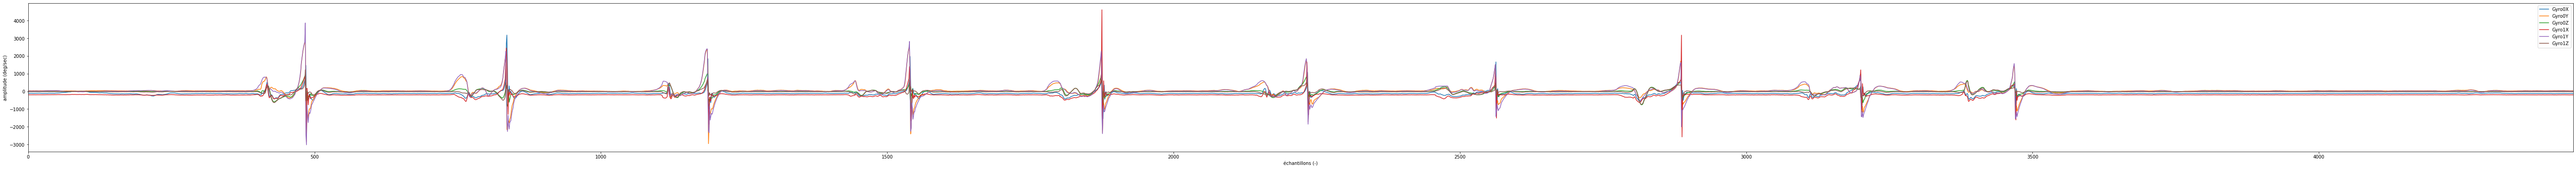

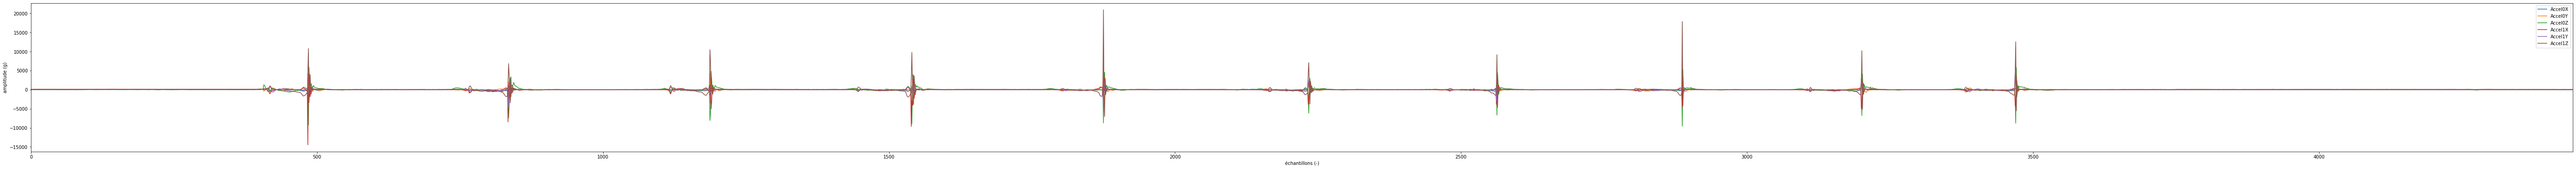

In [116]:
largeur=100
hauteur=6

ext = ".txt"

dancer = "/Ilyas"

step_type = "/step"

filename = "/step_full_1"

#path_raw = 'etapdance2/dig/dig.txt'
path_raw  =  "etapdance2" + dancer + step_type + filename + ext

#data_raw = pandas.read_csv(path_raw,names=['Time (ms)','Gyro0X (deg)','Gyro0Y (deg)','Gyro0Z (deg)','Accel0X (g)','Accel0Y (g)','Accel0Z (g)','Gyro1X (deg)','Gyro1Y (deg)','Gyro1Z (deg)','Accel1X (g)','Accel1Y (g)','Accel1Z (g)'], dtype='a') 
data_raw = pandas.read_csv(path_raw,names=['Gyro0X (deg)','Gyro0Y (deg)','Gyro0Z (deg)','Accel0X (g)','Accel0Y (g)','Accel0Z (g)','Gyro1X (deg)','Gyro1Y (deg)','Gyro1Z (deg)','Accel1X (g)','Accel1Y (g)','Accel1Z (g)'], dtype='a') 

#Time = np.array(data_raw['Time (ms)'])[1:].astype(float)

# MPU0 6050 (talon)
Gyro0X = np.array(data_raw['Gyro0X (deg)'])[1:].astype(float)
Gyro0Y = np.array(data_raw['Gyro0Y (deg)'])[1:].astype(float)
Gyro0Z = np.array(data_raw['Gyro0Z (deg)'])[1:].astype(float)

Accel0X = np.array(data_raw['Accel0X (g)'])[1:].astype(float)
Accel0Y = np.array(data_raw['Accel0Y (g)'])[1:].astype(float)
Accel0Z = np.array(data_raw['Accel0Z (g)'])[1:].astype(float)

#on enlève les offset DC de gravité
# https://stackoverflow.com/questions/18248102/removal-of-dc-offset-using-highpass-fft-filter
Accel0X = Accel0X - np.mean(Accel0X)
Accel0Y = Accel0Y - np.mean(Accel0Y)
Accel0Z = Accel0Z - np.mean(Accel0Z)

# MPU1 6050 (pointe)
Gyro1X = np.array(data_raw['Gyro1X (deg)'])[1:].astype(float)
Gyro1Y = np.array(data_raw['Gyro1Y (deg)'])[1:].astype(float)
Gyro1Z = np.array(data_raw['Gyro1Z (deg)'])[1:].astype(float)

Accel1X = np.array(data_raw['Accel1X (g)'])[1:].astype(float)
Accel1Y = np.array(data_raw['Accel1Y (g)'])[1:].astype(float)
Accel1Z = np.array(data_raw['Accel1Z (g)'])[1:].astype(float)

#on enlève les offset DC de gravité
Accel1X = Accel1X - np.mean(Accel1X)
Accel1Y = Accel1Y - np.mean(Accel1Y)
Accel1Z = Accel1Z - np.mean(Accel1Z)

signal = Accel0Z

plt.figure(figsize=(largeur,hauteur))
plt.plot(Gyro0X,label='Gyro0X')
plt.plot(Gyro0Y,label='Gyro0Y')
plt.plot(Gyro0Z,label='Gyro0Z')
plt.plot(Gyro1X,label='Gyro1X')
plt.plot(Gyro1Y,label='Gyro1Y')
plt.plot(Gyro1Z,label='Gyro1Z')
plt.ylabel('amplitude (deg/sec)')
plt.xlabel('échantillons (-)')
plt.autoscale(axis='x',tight=True);
plt.legend()
#plt.savefig(fname='couplage_AC_step.png')
plt.show()

plt.figure(figsize=(largeur,hauteur))
plt.plot(Accel0X,label='Accel0X')
plt.plot(Accel0Y,label='Accel0Y')
plt.plot(Accel0Z,label='Accel0Z')
plt.plot(Accel1X,label='Accel1X')
plt.plot(Accel1Y,label='Accel1Y')
plt.plot(Accel1Z,label='Accel1Z')
plt.ylabel('amplitude (g)')
plt.xlabel('échantillons (-)')
plt.autoscale(axis='x',tight=True);
plt.legend()
#plt.savefig(fname='couplage_AC_step.png')
plt.show()

In [117]:
# http://stevemorphet.weebly.com/speech-and-audio-processing/speech-and-audio-processing-part-2
fs = 91

len(signal)
sampsPerSec = fs
SecPerFrame = 0.15
sampsPerFrame = int(sampsPerSec * SecPerFrame)
nFrames = int(len(signal) / sampsPerFrame)        # number of non-overlapping _full_ frames
 
print('samples/second  ==> ', sampsPerSec)
print('samples/[%ds]frame  ==> ' % SecPerFrame, sampsPerFrame)
print('number of frames     ==> ', nFrames)
print(len(signal))

samples/second  ==>  91
samples/[0s]frame  ==>  13
number of frames     ==>  341
4445


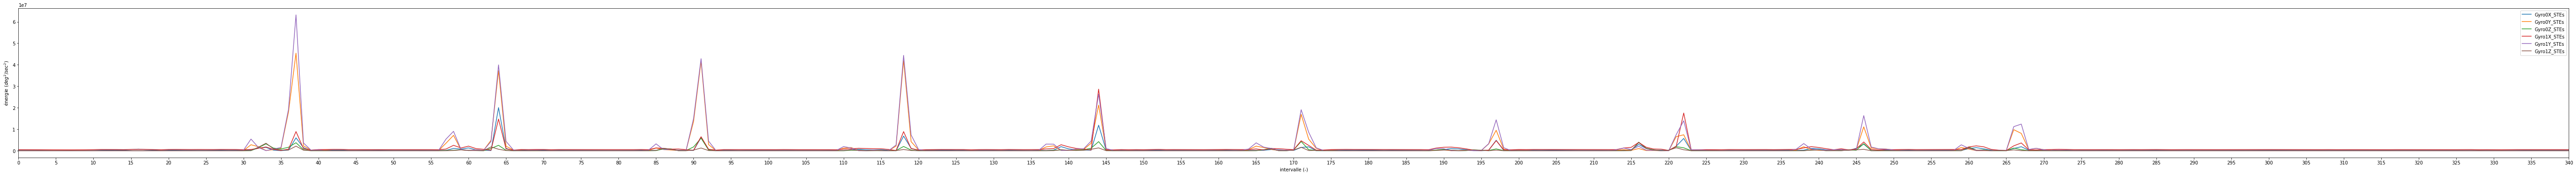

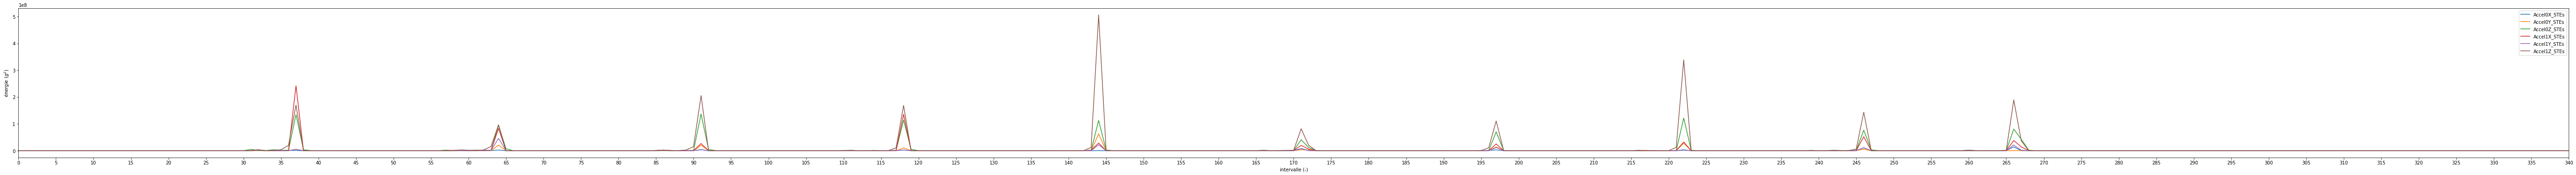

In [118]:
# http://stevemorphet.weebly.com/speech-and-audio-processing/speech-and-audio-processing-part-2
Gyro0X_STEs = []
Gyro0Y_STEs = []
Gyro0Z_STEs = []
Gyro1X_STEs = []
Gyro1Y_STEs = []
Gyro1Z_STEs = []

Accel0X_STEs = []
Accel0Y_STEs = []
Accel0Z_STEs = []
Accel1X_STEs = []
Accel1Y_STEs = []
Accel1Z_STEs = []

for k in range(nFrames):
    startIdx = k * sampsPerFrame
    stopIdx = startIdx + sampsPerFrame
    window = np.zeros(signal.shape)
    window[startIdx:stopIdx] = 1 # rectangular window
    # Gyroscopes
    STE = sum((Gyro0X ** 2) * (window ** 2))
    Gyro0X_STEs.append(STE)
    STE = sum((Gyro0Y ** 2) * (window ** 2))
    Gyro0Y_STEs.append(STE)
    STE = sum((Gyro0Z ** 2) * (window ** 2))
    Gyro0Z_STEs.append(STE)
    STE = sum((Gyro1X ** 2) * (window ** 2))
    Gyro1X_STEs.append(STE)
    STE = sum((Gyro1Y ** 2) * (window ** 2))
    Gyro1Y_STEs.append(STE)
    STE = sum((Gyro1Z ** 2) * (window ** 2))
    Gyro1Z_STEs.append(STE)
    
    # Accéleromètres
    STE = sum((Accel0X ** 2) * (window ** 2))
    Accel0X_STEs.append(STE)
    STE = sum((Accel0Y ** 2) * (window ** 2))
    Accel0Y_STEs.append(STE)
    STE = sum((Accel0Z ** 2) * (window ** 2))
    Accel0Z_STEs.append(STE)
    STE = sum((Accel1X ** 2) * (window ** 2))
    Accel1X_STEs.append(STE)
    STE = sum((Accel1Y ** 2) * (window ** 2))
    Accel1Y_STEs.append(STE)
    STE = sum((Accel1Z ** 2) * (window ** 2))
    Accel1Z_STEs.append(STE)

plt.figure(figsize=(largeur,hauteur))
plt.plot(Gyro0X_STEs,label='Gyro0X_STEs')
plt.plot(Gyro0Y_STEs,label='Gyro0Y_STEs')
plt.plot(Gyro0Z_STEs,label='Gyro0Z_STEs')
plt.plot(Gyro1X_STEs,label='Gyro1X_STEs')
plt.plot(Gyro1Y_STEs,label='Gyro1Y_STEs')
plt.plot(Gyro1Z_STEs,label='Gyro1Z_STEs')
plt.ylabel('énergie ($deg^2/sec^2$)')
plt.xlabel('intervalle (-)')
plt.xticks(np.arange(0, nFrames, step=5))
plt.autoscale(axis='x',tight=True);
plt.legend()
#plt.savefig(fname='couplage_AC_step.png')
plt.show()    
    
plt.figure(figsize=(largeur,hauteur))
plt.plot(Accel0X_STEs,label='Accel0X_STEs')
plt.plot(Accel0Y_STEs,label='Accel0Y_STEs')
plt.plot(Accel0Z_STEs,label='Accel0Z_STEs')
plt.plot(Accel1X_STEs,label='Accel1X_STEs')
plt.plot(Accel1Y_STEs,label='Accel1Y_STEs')
plt.plot(Accel1Z_STEs,label='Accel1Z_STEs')
plt.ylabel('énergie ($g^2$)')
plt.xlabel('intervalle (-)')
plt.xticks(np.arange(0, nFrames, step=5))
plt.autoscale(axis='x',tight=True);
plt.legend()
#plt.savefig(fname='couplage_AC_step.png')
plt.show()

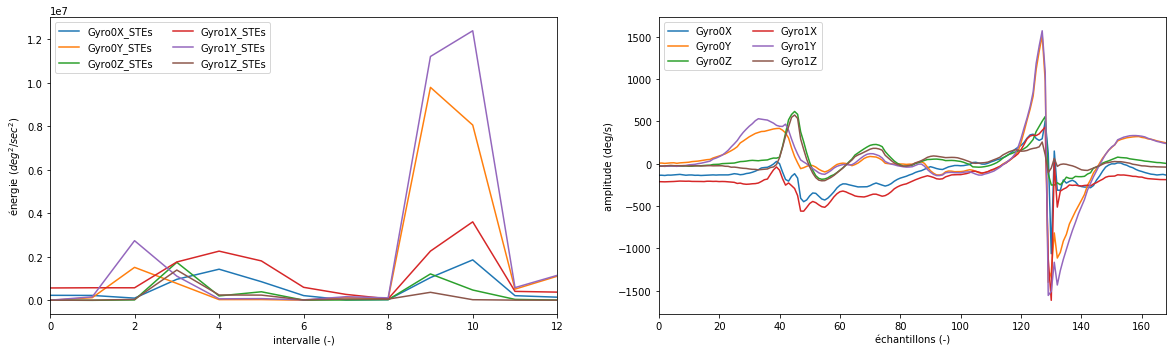

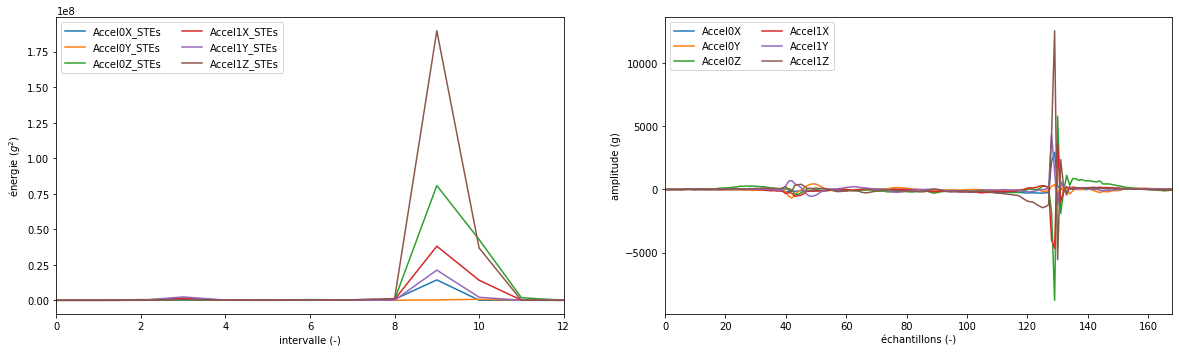

etapdance2/Ilyas/step/step_raw/step_raw_30.txt


In [148]:
start = 257
end = 270

start_sample = sampsPerFrame*start
end_sample = sampsPerFrame*end

largeur=20
hauteur=12

plt.figure(figsize=(largeur,hauteur))
plt.subplot(2, 2, 1)
plt.plot(Gyro0X_STEs[start:end],label='Gyro0X_STEs')
plt.plot(Gyro0Y_STEs[start:end],label='Gyro0Y_STEs')
plt.plot(Gyro0Z_STEs[start:end],label='Gyro0Z_STEs')
plt.plot(Gyro1X_STEs[start:end],label='Gyro1X_STEs')
plt.plot(Gyro1Y_STEs[start:end],label='Gyro1Y_STEs')
plt.plot(Gyro1Z_STEs[start:end],label='Gyro1Z_STEs')
plt.ylabel('énergie ($deg^2/sec^2$)')
plt.xlabel('intervalle (-)')
plt.autoscale(axis='x',tight=True);
plt.legend(loc='upper left',ncol=2)
plt.subplot(2, 2, 2)
plt.plot(Gyro0X[start_sample:end_sample],label='Gyro0X')
plt.plot(Gyro0Y[start_sample:end_sample],label='Gyro0Y')
plt.plot(Gyro0Z[start_sample:end_sample],label='Gyro0Z')
plt.plot(Gyro1X[start_sample:end_sample],label='Gyro1X')
plt.plot(Gyro1Y[start_sample:end_sample],label='Gyro1Y')
plt.plot(Gyro1Z[start_sample:end_sample],label='Gyro1Z')
plt.ylabel('amplitude (deg/s)')
plt.xlabel('échantillons (-)')
plt.autoscale(axis='x',tight=True);
plt.legend(loc='upper left',ncol=2)
#plt.savefig(fname='segment_step_accel0Z.png')
#plt.show()

plt.figure(figsize=(largeur,hauteur))
plt.subplot(2, 2, 3)
plt.plot(Accel0X_STEs[start:end],label='Accel0X_STEs')
plt.plot(Accel0Y_STEs[start:end],label='Accel0Y_STEs')
plt.plot(Accel0Z_STEs[start:end],label='Accel0Z_STEs')
plt.plot(Accel1X_STEs[start:end],label='Accel1X_STEs')
plt.plot(Accel1Y_STEs[start:end],label='Accel1Y_STEs')
plt.plot(Accel1Z_STEs[start:end],label='Accel1Z_STEs')
plt.ylabel('énergie ($g^2$)')
plt.xlabel('intervalle (-)')
plt.autoscale(axis='x',tight=True);
plt.legend(loc='upper left',ncol=2)
plt.subplot(2, 2, 4)
plt.plot(Accel0X[start_sample:end_sample],label='Accel0X')
plt.plot(Accel0Y[start_sample:end_sample],label='Accel0Y')
plt.plot(Accel0Z[start_sample:end_sample],label='Accel0Z')
plt.plot(Accel1X[start_sample:end_sample],label='Accel1X')
plt.plot(Accel1Y[start_sample:end_sample],label='Accel1Y')
plt.plot(Accel1Z[start_sample:end_sample],label='Accel1Z')
plt.ylabel('amplitude (g)')
plt.xlabel('échantillons (-)')
plt.autoscale(axis='x',tight=True);
plt.legend(loc='upper left',ncol=2)
#plt.savefig(fname='segment_step_accel0Z.png')
plt.show()

step_type_nb = "30"
path =  "etapdance2" + dancer + step_type + step_type + "_raw" + step_type + "_raw_"
data_output = path + step_type_nb + ext

print(data_output)

In [149]:
headers=['Gyro0X (deg)','Gyro0Y (deg)','Gyro0Z (deg)',
         'Accel0X (g)','Accel0Y (g)','Accel0Z (g)',
         'Gyro1X (deg)','Gyro1Y (deg)','Gyro1Z (deg)',
         'Accel1X (g)','Accel1Y (g)','Accel1Z (g)']

df = pandas.DataFrame({'Gyro0X (deg)': Gyro0X[start_sample:end_sample],
                       'Gyro0Y (deg)': Gyro0Y[start_sample:end_sample],
                       'Gyro0Z (deg)': Gyro0Z[start_sample:end_sample],
                       'Accel0X (g)' : Accel0X[start_sample:end_sample],
                       'Accel0Y (g)' : Accel0Y[start_sample:end_sample],
                       'Accel0Z (g)' : Accel0Z[start_sample:end_sample],
                       'Gyro1X (deg)': Gyro1X[start_sample:end_sample],
                       'Gyro1Y (deg)': Gyro1Y[start_sample:end_sample],
                       'Gyro1Z (deg)': Gyro1Z[start_sample:end_sample],
                       'Accel1X (g)' : Accel1X[start_sample:end_sample],
                       'Accel1Y (g)' : Accel1Y[start_sample:end_sample],
                       'Accel1Z (g)' : Accel1Z[start_sample:end_sample]})

df.to_csv(path_or_buf=data_output,index=False)